In [1]:
!nvidia-smi

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Fri Mar 17 01:45:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0  On |                  N/A |
| 32%   50C    P8    42W / 420W |    914MiB / 24576MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

In [31]:
%load_ext tensorboard

In [33]:
%tensorboard --logdir './Tensorflow/workspace/mymodel/train/'

In [2]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

2023-03-17 02:01:42.162277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:01:42.168736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:01:42.168761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('./Tensorflow/workspace/coco/Script/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('./Tensorflow/workspace/mymodel/ckpt-3').expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2023-03-17 01:46:13.212032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 01:46:13.294383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 01:46:13.295368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 01:46:13.300772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-17 01:46:13.301887: I tensorflow/compile

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
category_index = label_map_util.create_category_index_from_labelmap('./Tensorflow/workspace/annotations/label_map.pbtxt')

In [10]:
IMAGE_PATH = './Tensorflow/workspace/images/test/6538771b-IMG_2726.JPG'

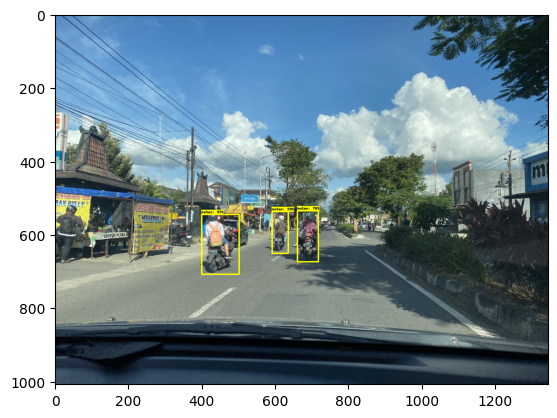

In [11]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=15,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

<h4>4. Freez The Model </h4>

In [3]:
FREEZE_SCRIPT = os.path.join('Tensorflow/models/research/object_detection', 'exporter_main_v2.py ')


In [14]:
!mkdir -p './Tensorflow/workspace/mymodel/export'

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [4]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,'./Tensorflow/workspace/coco/Script/pipeline.config', './Tensorflow/workspace/mymodel', './Tensorflow/workspace/mymodel/export')

In [5]:
print(command)

python Tensorflow/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=./Tensorflow/workspace/coco/Script/pipeline.config --trained_checkpoint_dir=./Tensorflow/workspace/mymodel --output_directory=./Tensorflow/workspace/mymodel/export


In [6]:
!{command}

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
2023-03-17 02:02:16.261306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:02:16.264415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:02:16.264494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the miss

<h4> 4. Create TFlite for Future Project </h4>

In [8]:
!mkdir -p './Tensorflow/workspace/Tflite'
TFLITE_SCRIPT = os.path.join('Tensorflow/models/research/object_detection', 'export_tflite_graph_tf2.py ')

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [9]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,'./Tensorflow/workspace/coco/Script/pipeline.config','./Tensorflow/workspace/mymodel', './Tensorflow/workspace/Tflite')

In [10]:
!{command}

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
2023-03-17 02:11:51.397566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:11:51.404749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:11:51.404909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the miss

In [12]:
FROZEN_TFLITE_PATH = os.path.join('./Tensorflow/workspace/Tflite/', 'saved_model')
TFLITE_MODEL = os.path.join('./Tensorflow/workspace/Tflite/', 'saved_model', 'detect.tflite')

In [13]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [14]:
!{command}

/usr/bin/zsh: /home/dimask/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
2023-03-17 02:15:30.920790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:15:30.924302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dimask/miniconda3/lib/:/home/dimask/miniconda3/envs/tfod3/lib/
2023-03-17 02:15:30.924433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the miss